In [6]:
!pip install torchmetrics
import torchmetrics
from torch.utils.data import Dataset
import torch
import pandas as pd

# Example Simple Neural Network [Optional Example]

###  This is an additional example. You can skip to Convolutional Neural Network below. 
### Check the M2 Notebook for a detailed example of simple neural networks

In [7]:
class WaterDataset(Dataset): # inherits the Dataset class from torch
    def __init__(self, csv_path):
        super().__init__() # initializes the constructor of the base class Dataset
        df = pd.read_csv(csv_path)
        self.data = df.to_numpy().astype('float32')
    def __len__(self):
        return self.data.shape[0] # return the size of the dataset
    def __getitem__(self, idx): # to select a specific row in the data based on index (idx)
        features = self.data[idx, :-1] # selects everything except the last colum, which is the label.
        label = self.data[idx, -1] # selects the last column
        return features, label # returns the features and label as a tuple

In [8]:
dataset_train = WaterDataset(
    "./water_potability/water_train.csv"
)

In [9]:
from torch.utils.data import DataLoader

dataloader_train = DataLoader(
    dataset_train,
    batch_size=2,
    shuffle=True
)


In [10]:
features, labels = next(iter(dataloader_train)) # dataloader_train as a container holding many batches of data. iter() gives you a handle to start going through this container, and next() is like saying "give me the next batch".


print(f"FeaturesL: {features}, \nLabels: {labels}")

FeaturesL: tensor([[0.5223, 0.5710, 0.3230, 0.4548, 0.6447, 0.5836, 0.3985, 0.3154, 0.7877],
        [0.1995, 0.3021, 0.3028, 0.0944, 0.7504, 0.3150, 0.4272, 0.5877, 0.2636]]), 
Labels: tensor([1., 1.])


In [11]:
from torch import nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(9,16)
        self.fc2 = nn.Linear(16,8)
        self.fc3 = nn.Linear(8,1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

net = Net()        

In [12]:
features.dtype

torch.float32

In [13]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

net.train()
for epoch in range(10):
    for features, labels in dataloader_train:
        optimizer.zero_grad()
        outputs = net(features)
        outputs = outputs.squeeze(1)  # Remove the extra dimension
        loss= criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [14]:
from torchmetrics import Accuracy
acc = Accuracy("binary")

net.eval()

with torch.no_grad():
    for features, labels in dataloader_train:
        outputs = net(features)
        preds = (outputs > 0.5).float()
        acc(preds, labels.view(-1,1))
        
accuracy = acc.compute()
print(f"Accuracy: {accuracy}")

Accuracy: 0.5988063812255859


# Convolutional Neural Network

### Loading images to PyTorch

In [15]:
from torchvision import transforms
from torchvision.datasets import ImageFolder

train_transforms = transforms.Compose([ # to chain multiple image transformations together.  It takes a list of transformations as input and applies them sequentially.
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.Resize((128,128)), # This transformation resizes the input image to a fixed size of 128x128 pixels.  Resizing images to a consistent size is crucial because many neural networks expect input images to have the same dimensions.
    transforms.ToTensor(), # converts Image into a PyTorch tensor. This conversion also typically scales the pixel values from the range [0, 255] to [0, 1], which is often beneficial for model training.

])

dataset_train = ImageFolder(
    "clouds/clouds_train",
    transform = train_transforms
)

In [16]:
dataloader_train = DataLoader(
    dataset_train,
    shuffle=True,
    batch_size=1
)

image, label = next(iter(dataloader_train))
print(image.shape)

torch.Size([1, 3, 128, 128])


torch.Size([128, 128, 3])


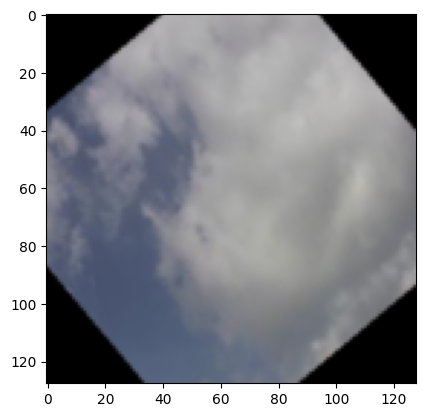

In [17]:
image= image.squeeze().permute(1,2,0)
print(image.shape)

import matplotlib.pyplot as plt
plt.imshow(image)
plt.show()

### Building the neural network

In [18]:
class Net(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.feature_extractor = nn.Sequential( # This creates a sequential container that holds a series of layers. The input data will pass through these layers in the order they are defined.

            #!!! Add a 2D convolutional layer using the nn.Conv2d function. The parameter values are given in the description.
            # This is a 2D convolutional layer, the core building block of many computer vision models. It applies a set of learnable filters to the input image to extract features like edges, corners, and textures.
                 # - in_channels=3:  The input image has 3 channels (likely RGB - red, green, blue).
                 # - out_channels=32: This layer produces 32 feature maps (or channels) as output.
                 # - kernel_size=3: Each filter is a 3x3 square.
                 # - padding=1:  Padding adds a border of pixels around the input to ensure the output size is the same as the input.
                 
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1), 
            
            #!!! Call the ELU function from  nn
            #This is an Exponential Linear Unit activation function. It introduces non-linearity to the model, allowing it to learn more complex patterns.
            nn.ELU(),
        
            #!!! Use the MaxPool2d function from nn, with kernel size of 2 for downsampling.
            # This is a 2D max pooling layer. It downsamples the feature maps by taking the maximum value within each 2x2 window. This reduces the spatial dimensions of the feature maps, making the network more robust to variations in the input and reducing the computational cost.
            nn.MaxPool2d(kernel_size=2),

            #!!! Add a 2D convolutional layer 
            
            # This is another convolutional layer, similar to the first one. However, it takes the 32 feature maps from the previous layer as input and produces 64 feature maps as output. Uses the same kernel size and padding. 
             # This allows the network to learn hierarchical features, where the second layer builds upon the features extracted by the first layer, capturing more complex patterns.
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            
            #!!! Add another ELU activitaion function
             #  Another ELU activation function to introduce non-linearity after the second convolutional layer.
            nn.ELU(),

            #!!! Do one more pooling 
             # Another max pooling layer to downsample the feature maps further.
            nn.MaxPool2d(kernel_size=2),
            
            
            nn.Flatten() # This layer flattens the multi-dimensional feature maps into a single vector. This is necessary to connect the convolutional layers (which operate on spatial data) to the fully connected layers (which operate on vectors).
        )
        
        self.classifier = nn.Linear(in_features=64*32*32, out_features=num_classes) # This line of code creates a linear layer, which is also known as a fully connected layer, and assigns it to the self.classifier attribute of your neural network model. This layer is a crucial component in your network as it's responsible for taking the extracted features from the previous layers and performing the final classification.
        
        # in_features=64*32*32: This specifies the number of input features to the linear layer. In your case, it's calculated as 64 * 32 * 32. This number comes from the output shape of the previous layer (nn.Flatten()). After the convolutional layers and pooling operations, the nn.Flatten() layer transforms the multi-dimensional feature maps into a single vector with 64 * 32 * 32 elements.
        
        # out_features=num_classes: This specifies the number of output features from the linear layer. This is the same as the number of classes you want your network to predict. For example, if you're classifying images into 10 categories (like digits 0-9), num_classes would be 10.
        
        
    def forward(self, x):
        #!!! Call the feature_extracter method of the self. Pass x as the parameter. Assign the output back to x, that means x =...
        # Remember that feature_extractor is a sequence of convolutional layers, activation functions, and pooling layers. These layers work together to extract relevant features from the input data, such as edges, textures, and shapes.
        x = self.feature_extractor(x)
        
        #!!! Use the classifier of the self, passing x as the parameter. Assign the output back to x, that means x = ...
        # This line takes the output from the feature_extractor (which is now a flattened vector of features) and passes it through the classifier component. The classifier is a linear layer (fully connected layer) that maps the extracted features to the desired output classes.  It essentially makes predictions based on the learned features.
        x = self.classifier(x)
        return x
    
        # In essence, the forward method defines the flow of data through the network:
        #   * Feature Extraction: The input data is processed by a series of convolutional layers to extract meaningful features.
        #   * Classification: The extracted features are then fed into a linear layer to make predictions about the input's class.


### Training loop

In [19]:
net = Net(num_classes=7) # This line creates an instance of the neural network (Net). We're passing num_classes=7 to specify that the network should output predictions for 7 different classes.

criterion = nn.CrossEntropyLoss() #  This defines the loss function used to train the network. nn.CrossEntropyLoss() is commonly used for multi-class classification problems. It calculates the difference between the predicted probability distribution and the true label. Importantly, it combines the softmax function (to convert raw scores into probabilities) and the negative log-likelihood loss into a single, efficient operation.

optimizer = optim.Adam(net.parameters(), lr=0.001) # This creates an Adam optimizer to update the network's parameters during training.

for epoch in range(10): # This loop iterates over 10 training epochs.
    
    running_loss = 0.0 # This initializes a variable to keep track of the total loss within each epoch.
    
    for images, labels in dataloader_train: # This inner loop iterates over the batches of data provided by your dataloader_train.
        
        #!!! Call the zero_grad method of the optimizer
        # This clears the gradients from the previous iteration.
        optimizer.zero_grad()
        
        #!!! Pass the input to the net object to obtain the results and assign them to outputs variable. 
        # This passes the input images to the network to get the predictions (outputs). These outputs are often called "logits" and represent raw scores for each class before being converted into probabilities.
        outputs = net(images)
        
        #!!! Apply criterion function which receives outputs and labels as parameters. Assign the outcome to the loss variable.
        # This calculates the loss between the network's predictions (outputs) and the true labels (labels) using the CrossEntropyLoss function.
        loss = criterion(outputs, labels)
        
        # Call the backward method of the loss function 
        # This performs backpropagation, calculating the gradients of the loss with respect to the network's parameters.
        loss.backward()
        
        #!!! Call the step function of the optimizer
        # This updates the network's parameters based on the calculated gradients to minimize the loss.
        optimizer.step()
        
        running_loss += loss.item() # This adds the loss value of the current batch to the running_loss.

    epoch_loss = running_loss / len(dataloader_train) # This calculates the average loss for the epoch.
    
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")
        

Epoch 1, Loss: 2.4639
Epoch 2, Loss: 1.9577
Epoch 3, Loss: 2.0067
Epoch 4, Loss: 1.6712
Epoch 5, Loss: 3.3146
Epoch 6, Loss: 1.4332
Epoch 7, Loss: 1.3638
Epoch 8, Loss: 1.5312
Epoch 9, Loss: 1.4749
Epoch 10, Loss: 3.2429


### Evaluation loop

In [20]:
test_transforms = transforms.Compose([
    #
    # No Data Augmentation at test time
    #
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

dataset_test = ImageFolder(
    "clouds/clouds_test",
    transform=test_transforms
)

dataloader_test = DataLoader(
    dataset_test,
    shuffle=True,
    batch_size=1
)

In [21]:
from torchmetrics import Precision, Recall

metric_precision = Precision(
    task="multiclass", num_classes=7, average="macro"
)

metric_recall = Recall(
    task="multiclass", num_classes=7, average="macro"
)

net.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        
        outputs = net(images)
        
        _, preds = torch.max(outputs, 1) # This finds the maximum value along dimension 1 of the outputs tensor. Dimension 1 corresponds to the different classes in your model. It returns two values: the maximum values themselves and their indices. We're interested in the indices, which represent the predicted class labels. The underscore _ is used to discard the maximum values, as we only need the preds. 
        
        #!!! call metric_precision function passing preds and labels as parameters.
        # stores the calculated precision values for each batch during the iteration through the test data.
        metric_precision(preds, labels)
        
        

        #!!! call metric_recall function passing preds and labels as parameters.
        # similarly this  calculates precision for a single batch, ALSO it keeps track of the necessary information across all batches
        metric_recall(preds, labels)

precision = metric_precision.compute()
recall = metric_recall.compute()

print(f"Precision: {precision}, \nRecall: {recall}")
        

Precision: 0.2690209746360779, 
Recall: 0.25917017459869385


In [22]:
_, preds, outputs

(tensor([9.6036]),
 tensor([3]),
 tensor([[  3.6637, -27.7305,  -6.6893,   9.6036,   4.6864,   6.7768,  -7.3377]]))

### Analyzing the performance per class

In [23]:
# Define precision metric
metric_precision = Precision(
    task="multiclass", num_classes=7, average=None
)

net.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
precision = metric_precision.compute()

print(precision)

tensor([0.2479, 0.0000, 0.5000, 0.2943, 0.7500, 0.0909, 0.0000])


In [24]:
dataset_test.class_to_idx.items()

dict_items([('cirriform clouds', 0), ('clear sky', 1), ('cumulonimbus clouds', 2), ('cumulus clouds', 3), ('high cumuliform clouds', 4), ('stratiform clouds', 5), ('stratocumulus clouds', 6)])

In [25]:
# Get precision per class
precision_per_class = {
    k: precision[v].item() for k, v in dataset_test.class_to_idx.items()
}
print(precision_per_class)

{'cirriform clouds': 0.24793387949466705, 'clear sky': 0.0, 'cumulonimbus clouds': 0.5, 'cumulus clouds': 0.2943038046360016, 'high cumuliform clouds': 0.75, 'stratiform clouds': 0.09090909361839294, 'stratocumulus clouds': 0.0}


# Recurrent Neural Networks

In [26]:
# Creating sequences in Python
import numpy as np

def create_sequences(df, seq_length):
    xs, ys = [], []
    for i in range(len(df) - seq_length):
        x = df.iloc[i : (i + seq_length), 1] # This selects rows from i to i + seq_length - 1 (slicing) and the column at index 1.
        y = df.iloc[i + seq_length, 1] # This selects the row at index i + seq_length and the column at index 1.
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [27]:
import pandas as pd

train_data = pd.read_csv('electricity_consump/electricity_train.csv')[:2000] # Here we select the first 2000 rows to save time in training
test_data = pd.read_csv('electricity_consump/electricity_test.csv')[:1000] # Here we select the first 1000 rows to save time in testing
seq_length = 24 * 4 # 24 hours

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)


In [28]:
print(X_train.shape) # we have 105,119 training samples, and each sample is a sequence of length 96.
print(X_test.shape) # 34,944 testing samples, each with a sequence length of 96.

(1904, 96)
(904, 96)


In [29]:
from torch.utils.data import TensorDataset

dataset_train = TensorDataset(
    torch.from_numpy(X_train).float(), 
    torch.from_numpy(y_train).float()
)

dataset_test = TensorDataset(
    torch.from_numpy(X_test).float(),
    torch.from_numpy(y_test).float()
    
)

dataloader_train = DataLoader(
    dataset_train,
    shuffle=True,
    batch_size=2
)

dataloader_test = DataLoader(
    dataset_test,
    shuffle=True,
    batch_size=2
)


In [30]:
class Net(nn.Module): # This line defines a class called Net that inherits from nn.Module. In PyTorch, nn.Module is the base class for all neural network modules. This means our LSTMnet will be a building block for constructing larger neural networks.
    def __init__(self):
        super().__init__( ) # This line calls the constructor of the parent class (nn.Module) to initialize its properties.
        
        #!!! Define an RNN using nn.RNN function. It should have input_size, hidden_size, num_layers, and batch_first properly defined. Check the descriptions below to figure out the values for each of them.
        self.rnn = nn.RNN( #  This is where we create the RNN layer.
            input_size=1,
            hidden_size=32,
            num_layers=2,
            batch_first=True


             # Each input to the RNN will be a single value (a scalar).

             #  The number of features in the hidden state of the RNN are 32. The hidden state is like the RNN's memory, and a larger size means it can remember more complex patterns.

             #  This RNN has 2 layers stacked on top of each other. Stacking layers can help the RNN learn more complex patterns.

             # The batch_first is true, which  means the input and output tensors will have the batch dimension first (batch_size, sequence_length, input_size). This is often preferred for efficiency.
        )
        
        #!!! Create a linear layer using the nn.Linear method, the input feature size is 32, and output feature size is 1. Assign the layer to self.cc
        # This creates a fully connected linear layer. This layer will take the output of the RNN and produce a single output value.
        self.fc = nn.Linear(32, 1)
    
    def forward(self, x): # This is the forward pass function. It defines how the input data flows through the network.
        
        #!!! Create the hidden state variable h0, by caling the zeros function of the torch. Pass 2, x.size(0), and 32 as the parameters. Their explanations are given below.
        # This initializes the initial hidden state (h0) of the RNN to zeros. The size is (num_layers, batch_size, hidden_size).
        h0 = torch.zeros(x.size(0), 2, 32)
        
        out, _ = self.rnn(x, h0) # This passes the input x and the initial hidden state h0 to the RNN layer. The RNN processes the input sequence and produces an output out and the final hidden state. We ignore the final hidden state here using _. 
        #  In this line, x is your actual input sequence (e.g., a series of numbers, words encoded as numbers, etc.). The rnn function processes this input sequence step-by-step, using h0 as the initial memory.

        # Inside the rnn function, the RNN cell repeatedly updates its hidden state as it processes each element of the input x. This updated hidden state captures the information from the sequence seen so far.
        
        out = self.fc(out[:, -1, :]) # This line extracts the output of the RNN at the last time step (out[:, -1, :]) and passes it to the fully connected layer (self.fc) to get the final output.
        
        # The out variable captures the output of the RNN at each time step. So, out will actually have the same length as your input sequence x.
        
        # out[:, -1, :] This line is important because it extracts only the last output from the RNN.  We often care most about the RNN's understanding of the entire sequence, which is reflected in the final output.
        
        # The self.fc (fully connected layer) acts as a final processing step. It takes the last output of the RNN (which is a vector of 32 values in this case) and transforms it into the desired output shape (a single value here). This allows the network to make a prediction or classification based on the entire input sequence.
        
        # That means it has two parts: 
        # It has two main parts:

        # 1. The RNN network (self.rnn): This is the core of the model, responsible for processing the sequential data and capturing temporal dependencies. It does the heavy lifting of analyzing the input step-by-step and updating its hidden state to maintain a memory of the sequence. 

        # 2. The fully connected layer (self.fc): This layer acts as the output layer of the network. It takes the final hidden state of the RNN (which represents the RNN's understanding of the entire sequence) and maps it to the desired output.  Think of it as the "decision-making" part of the network, taking the RNN's knowledge and using it to make a prediction or classification.

        # Why have both?
        
        # The RNN is great at handling sequences, but its output is often a complex representation that might not be directly suitable for the final task. The fully connected layer helps to simplify and tailor this output to the specific problem you're trying to solve.
        
        return out

### LSTM Networks

In [31]:
class LSTMnet(nn.Module):
    def __init__(self):
        super().__init__()
        # Define lstm layer
        
        #!!! Create an LSTM layer. The approach is very similar to creating RNN as you did above. 
        # This line creates an LSTM layer 
        # This means the LSTM layer expects an input sequence where each element has a size of 1 (e.g., a single value representing a time step in a time series).

        # This sets the number of features in the hidden state of the LSTM to 32. The hidden state is the LSTM's memory, where it stores information from previous time steps.

        # This creates an LSTM with 2 layers stacked on top of each other. Multiple layers can help the network learn more complex patterns.

        # This indicates that the input data will have the batch dimension first, followed by the sequence length and input size (e.g., [batch_size, sequence_length, input_size]).
        
        
        nn.LSTM(1, 32, 2, batch_first=True)

        #!!! Create a linear layer using the nn.Linear method, the input feature size is 32, and output feature size is 1. Assign the layer to self.cc
        # This layer takes the output of the LSTM (which has a size of 32) and maps it to a single output value.
        nn.Linear(32,1)

    def forward(self, x):
        #!!! Create the hidden state variable h0, by caling the zeros function of the torch. Pass 2, x.size(0), and 32 as the parameters. Their explanations are given below.
        # This line initializes the initial hidden state (h0) of the LSTM with zeros. It creates a tensor of zeros with dimensions:
            # 2: Number of LSTM layers.
            # x.size(0): Batch size of the input data.
            # 32: Hidden size of the LSTM.
        h0 = torch.zeros(2, x.size(0), 32)
        
        # !!! Create the hidden state variable c0, by caling the zeros function of the torch. Pass 2, x.size(0), and 32 as the parameters. Their explanations are given below. This is used for long term memory.
        # This line initializes the initial cell state (c0) of the LSTM with zeros. The cell state is another type of memory in LSTMs that helps to preserve information over longer periods. The dimensions are the same as the hidden state.
        c0 = torch.zeros(2, x.size(0), 32)
        
        # !!! Pass all inputs to lstm layer. One paramter is x, and the another parameter is the tuple of h0 and c0
        # This line passes the input data (x) and the initial hidden and cell states (h0, c0) to the LSTM layer. The LSTM processes the input sequence step-by-step and updates its hidden and cell states accordingly. The output (out) contains the hidden state at each time step, and the _ discards the final cell state.
        out, _ = self.lstm(x, (h0, c0))
        # !!! As it is done in RNN, extract the hidden state from the last time step
        # This line extracts the hidden state from the last time step (out[:, -1, :]) and passes it to the fully connected layer (self.fc) to generate the final output.
        out = self.fc(out[:, -1, :])
        # The code uses the last hidden state because it effectively summarizes the LSTM's processing of the entire input sequence and is often the most relevant information for generating the final output.
        
        
        return out

### GRU Networks

In [34]:
class GRUNet(nn.Module):
    def __init__(self, input_size = 1):
        super().__init__()
        
        #!!! Define GRU layer similar to the approach provided for LSTM layer above.
        self.gru = nn.GRU(input_size, 32, 2, batch_first=True)
        
        #!!! Define the linear layer
        self.fc = nn.Linear(32, 1)


    def forward(self, x):
        #!!! Create the hidden state variable h0, with the same parameters as in LSTM example
        # Initializes the initial hidden state (h0) of the GRU with zeros.
        h0 = torch.zeros(2, x.size(0), 32)

        # Passes the input data x to the gru network. The parameters are x and h0.
        # Passes the input data (x) and the initial hidden state (h0) to the GRU layer. The GRU processes the input sequence and updates its hidden state.  The output (out) contains the hidden state at each time step.
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :]) # This is the same as in the LSTM code. It extracts the hidden state from the last time step and passes it to the fully connected layer to produce the final output.
        
        return out
    
# Key Differences from LSTM:

    # * Simpler Architecture: GRUs have a simpler internal structure than LSTMs, with only two gates (reset and update gates) instead of three. This makes them computationally less expensive.
    # * Hidden State: GRUs only have a hidden state, while LSTMs have both a hidden state and a cell state.
    # * Performance: LSTMs and GRUs often achieve comparable performance, but GRUs can be faster to train due to their simpler architecture. The best choice depends on the specific task and dataset.

### Training loop

In [36]:
net = GRUNet() # This line creates an instance of the GRU network.  GRUNet is a custom class  which contains the architecture of your GRU model 

criterion = nn.MSELoss() # This defines the loss function to be used during training.  nn.MSELoss() calculates the Mean Squared Error, commonly used for regression tasks where you're predicting a continuous value.

optimizer = optim.Adam( #  This creates an Adam optimizer. Adam is a popular optimization algorithm that adapts the learning rate for each parameter.
    net.parameters(), #  provides all the trainable parameters of your GRU network to the optimizer. 
    lr=0.001
)

for epoch in range(2): # This loop iterates over two training epochs. An epoch means one complete pass through your entire training dataset.
    
    for seqs, labels in dataloader_train: # This inner loop iterates over the batches of data provided by your dataloader_train.  A data loader helps efficiently feed data to your model during training.
        
        batch_size = seqs.shape[0]  # This line dynamically determines the batch size from the data loader. This is useful if your last batch has a different size than the others.
        
        seqs = seqs.view(batch_size, 96, 1)  # This reshapes your input sequences (seqs). The sequences have a length of 96 and a single feature. This reshaping prepares the data to be fed into the GRU network.
        
        #!!! Write the necessary statement to obtain the predictions and assign them to outputs variable.
        # This is where you pass your input sequences to the GRU network (net) to get the predictions (outputs).
        outputs = net(seqs)
        
        
        #!!! Call the criterion with outputs and labels parameters. You have to apply unsqueeze(1) to the labels. Assign the outcome to the loss variable.
        # This calculates the loss between your network's predictions (outputs) and the true labels (labels).  labels.unsqueeze(1)  adds an extra dimension to the labels to match the shape of the outputs.
        loss = criterion(outputs, labels.unsqueeze(1))  # Compute loss
        
        #!!! Write necessary code to clear the gradients
        # This clears the gradients from the previous iteration. 
        optimizer.zero_grad()
        
        #!!! Call the proper method of the loss function
        # This performs backpropagation. It calculates the gradients of the loss with respect to the network's parameters.
        loss.backward()

        #!!! Call the proper method of the optimizer
        # This updates the network's parameters based on the calculated gradients, aiming to minimize the loss.
        optimizer.step()
        

### Evaluation Loop

In [37]:
mse = torchmetrics.MeanSquaredError() # This line creates an instance of the MeanSquaredError metric from the torchmetrics library. This object will be used to calculate the MSE between the network's predictions and the actual labels.

#!!! Write the necessary code to set the network in the evaluation mode
# This line sets your GRU network to evaluation mode. This is important because certain layers, like dropout, behave differently during training and evaluation.
net.eval()


with torch.no_grad(): # This context manager temporarily disables gradient calculations. This is crucial during evaluation because you don't need to update the network's weights anymore. It saves memory and speeds up computation.
    
    for seqs, labels in dataloader_test:
        seqs = seqs.view(2, 96, 1) #  This line reshapes your input sequences (seqs) to have a batch size of 2, a sequence length of 96, and a single feature. This is necessary to match the expected input shape of your GRU network.
        
        # Pass seqs to net and squeeze the result
        outputs = net(seqs).squeeze() # This line passes the input sequences (seqs) to your GRU network (net) to get the predictions (outputs).  .squeeze() removes any unnecessary dimensions from the output tensor.
        
        #!!! Call the mse with parameters outputs and labels
        # This line updates the mse metric with the network's predictions (outputs) and the corresponding true labels (labels). The mse object internally accumulates the squared errors between the predictions and labels.
        mse(outputs, labels)
        
#!!! Call the compute method of the mse
#  This line calculates the final MSE value by averaging the accumulated squared errors.
test_mse = mse.compute()

print(f"Test MSE: {test_mse}")

Test MSE: 0.0769309401512146
